In [55]:

# %matplotlib inline
%matplotlib inline
%load_ext autoreload
%autoreload 1

import os
import re
import glob
import pandas as pd
import numpy as np
import numpy.lib.recfunctions as rf
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial.distance import cdist

from ipywidgets import interactive, interactive_output, interact_manual

import ipywidgets as widgets
# import cv2
import time
import mediapy
import torch
from tqdm.notebook import tqdm
# mpl.rcParams['figure.figsize'] = [16.0, 12.0]

# %aimport plot_functions, seqslam_tools
# from seqslam_tools import seqSLAM_from_distMat, seqSLAM_from_distMatGPU, seqSLAM_from_distMatGPU_multi, seqSLAM_from_distMatGPU_multi_precomputed
# from plot_functions import compare_images_triple, plot_image_on_ax, getPRCurveWrapper, getPRCurveWrapperFromScores, getPAt100R, getPAt100RFromPRVals, getRAtXPFromPRVals

import seaborn as sns; sns.set(); sns.set_style("whitegrid"); sns.set_context("notebook")
# import seaborn_image as isns; isns.set_context("notebook"); isns.set_image(origin="upper")

import tonic
import tonic.transforms as transforms



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [57]:
# Load event stream
event_data_processed = np.load("Event_processed_1sec_bin.npz")
event_frames = event_data_processed["event_data_processed"]
print(type(event_frames))
print(len(event_frames))
print(event_frames[0].shape)
print(event_frames[1].shape)

<class 'numpy.ndarray'>
2
(164, 260, 346)
(164, 260, 346)


In [58]:
# Threshold to remove spurious event counts
# event_frames_thresh is the primary event stream for analysis
thresh = 15

print(np.count_nonzero(event_frames[0][event_frames[0] > thresh]))
print(np.count_nonzero(event_frames[0][event_frames[0] < thresh]) / np.count_nonzero(event_frames[0][event_frames[0] > thresh]))

event_frames_thresh = np.copy(event_frames)
event_frames_thresh[0][event_frames_thresh[0] > thresh] = thresh
event_frames_thresh[1][event_frames_thresh[1] > thresh] = thresh
print(event_frames_thresh[0].shape)
print(event_frames_thresh[1].shape)



238320
31.020955018462573
(164, 260, 346)
(164, 260, 346)


(164, 260, 346)
(164, 260, 346)


Text(0.5, 1.0, 'Event camera sum of events')

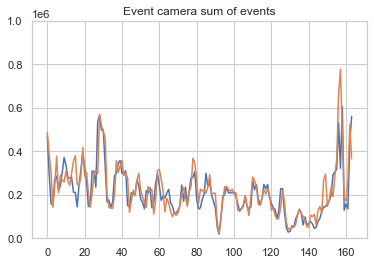

In [59]:
#plot the sum of events over all pixels over time
plt.figure()
for event_frame_total in event_frames_thresh:
    print(event_frame_total.shape)
    plt.plot(np.arange(len(event_frame_total)), event_frame_total.sum(axis=(1,2))) #sum over pixel axes to get total events for each binned time step
plt.ylim(0, 1e6)
plt.title('Event camera sum of events')

<AxesSubplot:title={'center':'Event camera mean of events'}>

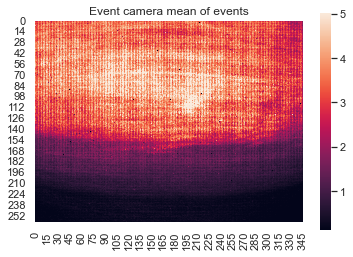

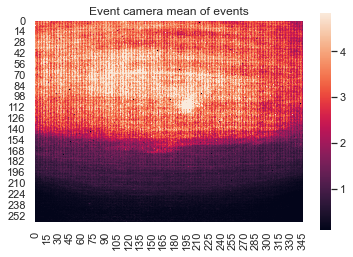

In [60]:
#plot the mean over the time axis to get an indication of the most active pixels
event_means = [event_frame_total.mean(axis=0) for event_frame_total in event_frames_thresh] #take the mean over the time dimension
plt.figure()
plt.title('Event camera mean of events')
sns.heatmap(event_means[1], robust=True, square=True, cbar=True)

plt.figure()
plt.title('Event camera mean of events')
sns.heatmap(event_means[0], robust=True, square=True, cbar=True)

(260, 346)
25468
[25468 21518 26406 ... 85066 87874 89959]
(73, 210)


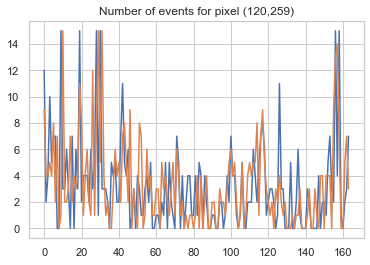

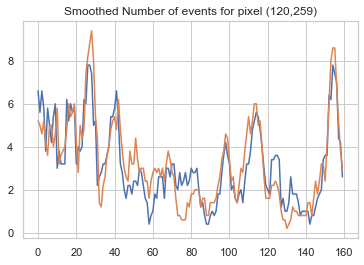

In [63]:
print(event_means[0].shape)
print(np.argmax(event_means[0])) #index of pixel with most events
print(np.argsort(event_means[0], axis = None)[::-1]) #pixel indices sorted in order of most pixels to least
print(np.unravel_index(np.argmax(event_means[0]), event_means[0].shape)) #coordinates of pixel with most events

top_pixels = np.argsort(event_means[0], axis = None)[::-1]

test_pixel_x = 120
test_pixel_y = 259
# Single pixel
plt.figure()
plt.title('Number of events for pixel (' + str(test_pixel_x) + ',' + str(test_pixel_y) + ')')
for event_frame_total in event_frames_thresh:
    plt.plot(np.arange(len(event_frame_total)), event_frame_total[:, test_pixel_x, test_pixel_y])
    # print(event_frame_total.shape)

plt.figure()
plt.title('Smoothed Number of events for pixel (' + str(test_pixel_x) + ',' + str(test_pixel_y) + ')')
smoothing_filter = 5
for event_frame_total in event_frames_thresh:
    plt.plot(np.arange(len(event_frame_total)-smoothing_filter+1), moving_average(event_frame_total[:, test_pixel_x, test_pixel_y], smoothing_filter))
    # print(event_frame_total.shape)

In [65]:


filter_size=100
number_of_pixels=1000
correlation_method = 'diff'

total_number_pixels = event_frames_thresh[0].shape[1]*event_frames_thresh[0].shape[2]
dmat_cumulative = np.zeros((len(event_frames_thresh[0])-filter_size+1,len(event_frames_thresh[0])-filter_size+1))

arr = np.arange(total_number_pixels)
np.random.shuffle(arr) #random selection of pixels
# arr = top_pixels

# dmat_cumulative = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))

for pixel_ind in tqdm(arr[0:number_of_pixels]):

    x_pix, y_pix = np.unravel_index(pixel_ind, event_means[0].shape)
    ref = event_frames_thresh[0][:,x_pix,y_pix]
    qry = event_frames_thresh[1][:,x_pix,y_pix]

    dmat = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))
    for filter_ind in np.arange(len(ref)-filter_size+1):
        filter = qry[filter_ind:filter_ind+filter_size]
        corr = np.correlate(ref, filter)
        corr_norm = corr / np.max(corr)

        corr_diff = np.zeros(corr.shape)
        for idx in np.arange(len(corr_diff)):
            corr_diff[idx] = np.sum(np.abs(ref[idx:idx+filter_size] - filter))
        corr_diff_norm = corr_diff / np.max(corr_diff)
        if correlation_method == "diff":
            dmat[:,filter_ind] = corr_diff #or corr
        else:
            dmat[:,filter_ind] = corr #or corr
        
    dmat_cumulative += dmat
dmat_cumulative /= np.max(dmat_cumulative)

if correlation_method == "corr":
    dmat_cumulative = 1-dmat_cumulative

sns.heatmap(dmat_cumulative, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix event camera')

np.savez("Results/dMat_test.npz", dMat=dmat_cumulative)

  0%|          | 0/1000 [00:00<?, ?it/s]

(164, 260, 346)
(164, 89960)


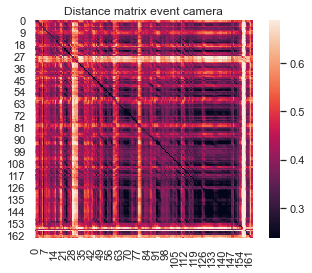

In [ ]:

ref_traverse = 0
query_traverse = 1
print(event_frames_total_thresh[ref_traverse].shape)
ref_vec = event_frames_total_thresh[ref_traverse].reshape(event_frames_total_thresh[ref_traverse].shape[0], -1)
qry_vec = event_frames_total_thresh[query_traverse].reshape(event_frames_total_thresh[query_traverse].shape[0], -1)
dMat = cdist(ref_vec, qry_vec ,'euclidean')
dMat /= np.max(dMat)
print(ref_vec.shape)

plt.figure()
sns.heatmap(dMat, robust=True, square=True, cbar=True)
_ = plt.title('Distance matrix event camera')

np.savez("Results/dMat_test2.npz", dMat=dMat)


In [ ]:
prob_to_draw_from = np.copy(event_means[0])
# prob_to_draw_from[np.logical_and(prob_to_draw_from < 0.5, prob_to_draw_from != 0.0)] = 0.01

# Set low prob for "hot pixels"
prob_to_draw_from[prob_to_draw_from > (event_means[0].mean() + 2*event_means[0].std())] = 0.01
prob_sum = prob_to_draw_from.sum()
prob_to_draw_from = prob_to_draw_from / prob_sum

recall_dict = {}
used_pixels_dict = {}
use_saliency = True

seq_length = 15
maxLocRad = 4
gt_tolerance = maxLocRad
precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
precomputed_convWeight_seq1 = torch.eye(1, device='cpu').unsqueeze(0).unsqueeze(0)

precomputed_convWeight = torch.eye(seq_length, device='cpu').unsqueeze(0).unsqueeze(0)
precomputed_convWeight_seq1 = torch.eye(1, device='cpu').unsqueeze(0).unsqueeze(0)

num_trials = 15

num_target_pixels_list = [1, 2, 5, 10, 20, 50, 100, 150, 200, 250]
# num_target_pixels_list = [8]

for num_target_pixels in tqdm(num_target_pixels_list):
    if num_target_pixels in recall_dict:
        tqdm.write('skip')
        continue

    recall_dict[num_target_pixels] = []
    used_pixels_dict[num_target_pixels] = []

    for _ in range(num_trials):
        target_pixels = []
        while len(target_pixels) < num_target_pixels:
            random_idx_flat = np.random.choice(np.arange(0, im_height*im_width), p=prob_to_draw_from.reshape(-1) if use_saliency else None)
            random_pixel = np.unravel_index(random_idx_flat, (im_height, im_width))
            if len(target_pixels) == 0 or np.all(np.linalg.norm(np.array(target_pixels) - np.array(random_pixel), axis=1) > 3):
                target_pixels.append(random_pixel)

        # target_pixels_x = np.array([100, 100, 100, 100, 100, 100, 100, 100])
        # target_pixels_y = np.array([0,   25,  50,  75, 100, 125, 150, 175])
        # target_pixels = np.vstack((target_pixels_x, target_pixels_y)).T

        dist_matrices = []
        for target_pixel in target_pixels:
            count_traverse_ref = torch.from_numpy(event_frames_total_cropped[0][:, target_pixel[1], target_pixel[0]].astype(np.float32)).unsqueeze(0)
            count_traverse_qry = torch.from_numpy(event_frames_total_cropped[1][:, target_pixel[1], target_pixel[0]].astype(np.float32)).unsqueeze(0)
            dist_matrix_single = torch.abs(count_traverse_ref.unsqueeze(2) - count_traverse_qry.unsqueeze(1)).to('cpu').type(torch.FloatTensor).unsqueeze(0).squeeze(-1)
            dist_matrices.append(dist_matrix_single)

        dist_matrices_stacked = torch.stack(dist_matrices)
        dist_matrices_summed = torch.mean(dist_matrices_stacked, 0)
        # seq_ret = seqSLAM_from_distMatGPU_multi_precomputed(dist_matrices_summed, precomputed_convWeight)
        # dist_matrix_seqslam = torch.nn.functional.conv2d(dist_matrices_summed, precomputed_convWeight).squeeze()
        # match_indices = seq_ret.indices.to('cpu').detach().numpy()
        # match_scores = seq_ret.values.to('cpu').detach().numpy()
        # # print(f'combined P@100R: {getPAt100R(match_indices, maxLocRad)[-1]:.2f}')

        # prvals = getPRCurveWrapperFromScores(match_indices, match_scores, gt_tolerance)

        # match_scores_revised = np.empty(match_scores.shape, dtype=np.float32)
        # for query in range(len(dist_matrix_seqslam)):
        #     refs_sorted = dist_matrix_seqslam[query].argsort()
        #     best_match = refs_sorted[0]
        #     second_best_match = refs_sorted[torch.abs(refs_sorted - best_match) >= 3][0]
        #     match_scores_revised[query] = dist_matrix_seqslam[query][best_match] / dist_matrix_seqslam[query][second_best_match]

        # prvals_revised = getPRCurveWrapperFromScores(match_indices, match_scores_revised, gt_tolerance)
        # # tqdm.write(f'combined R@99P: {getRAtXPFromPRVals(prvals_revised, 0.99):.2f}')

        # recall_dict[num_target_pixels].append(getRAtXPFromPRVals(prvals_revised, 0.99))
        # used_pixels_dict[num_target_pixels].append(target_pixels)

    mean_recall = np.mean(recall_dict[num_target_pixels])
    median_recall = np.median(recall_dict[num_target_pixels])
    # tqdm.write(f'mean R@99P: {mean_recall:.2f}; median R@99P: {median_recall:.2f}; worst R@99P: {np.array(recall_dict[num_target_pixels]).min():.2f}; best R@99P: {np.array(recall_dict[num_target_pixels]).max():.2f}')


  0%|          | 0/10 [00:00<?, ?it/s]

IndexError: index 284 is out of bounds for axis 1 with size 260

(20,)
max correlation index: 0
truth correlation index: 0
[ 5  4  0  0 10  5  3  1  4  1  6  1  3 11 14 11  1  2  9  6]
[ 6  0  6  7 10  2  1  0  4  5 12  4 11 15  7  4  2  6  6 10]
(145, 145)
(164,)


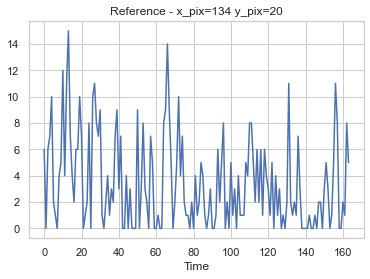

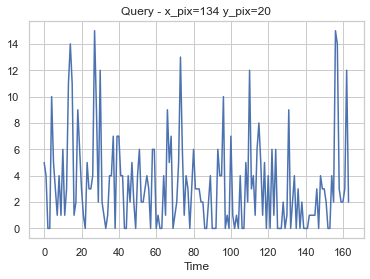

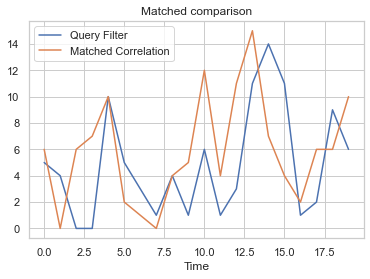

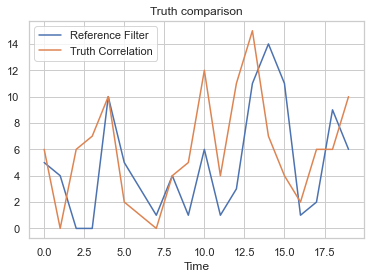

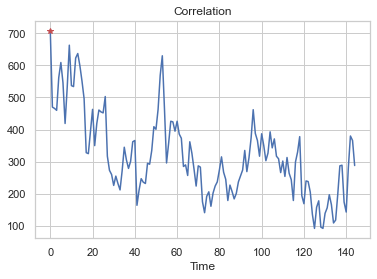

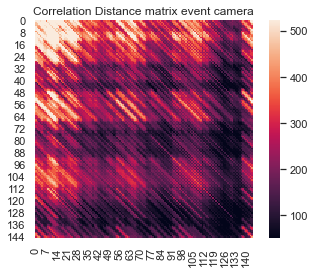

In [ ]:

x_pix = 134
y_pix = 20

# x_pix = 120
# y_pix = 259

ref = event_frames_total_thresh[0][:,x_pix,y_pix]
# print(event_frames_total_cropped[0].shape)
# print(ref.shape)
qry = event_frames_total_thresh[1][:,x_pix,y_pix]

filter_size = 20

filter_ind = 0
filter = qry[filter_ind:filter_ind+filter_size]
print(filter.shape)
corr = np.correlate(ref, filter)
max_corr = np.max(corr)
max_corr_ind = np.where(corr==max_corr)[0][0]
print("max correlation index: " + str(max_corr_ind))
print("truth correlation index: " + str(filter_ind))

i = max_corr_ind
print(filter)
print(ref[i:i+filter_size])

plt.figure()
plt.title("Reference - x_pix=" + str(x_pix) + " y_pix=" + str(y_pix))
plt.plot(np.arange(len(ref)), ref)
plt.xlabel("Time")

plt.figure()
plt.title("Query - x_pix=" + str(x_pix) + " y_pix=" + str(y_pix))
plt.plot(np.arange(len(qry)), qry)
plt.xlabel("Time")

plt.figure()
plt.title("Matched comparison")
plt.plot(np.arange(filter_size), filter)
plt.plot(np.arange(filter_size), ref[i:i+filter_size])
plt.legend(["Query Filter", "Matched Correlation"])
plt.xlabel("Time")

plt.figure()
plt.title("Truth comparison")
plt.plot(np.arange(filter_size), filter)
plt.plot(np.arange(filter_size), ref[filter_ind:filter_ind+filter_size])
plt.legend(["Reference Filter", "Truth Correlation"])
plt.xlabel("Time")

plt.figure()
plt.title("Correlation")
plt.plot(np.arange(len(corr)), corr)
plt.plot(max_corr_ind, max_corr, 'r*')
plt.xlabel("Time")

dmat_corr = np.zeros((len(ref)-filter_size+1,len(ref)-filter_size+1))
print(dmat_corr.shape)
print(ref.shape)
for filter_ind in np.arange(len(ref)-filter_size+1):
    filter = qry[filter_ind:filter_ind+filter_size]
    corr = np.correlate(ref, filter)

    corr_diff = np.zeros(corr.shape)
    for idx in np.arange(len(corr_diff)):
        corr_diff[idx] = np.sum(np.abs(ref[idx:idx+filter_size] - filter))
    corr_norm = corr / np.max(corr)
    corr_diff_norm = corr_diff / np.max(corr_diff)
    dmat_corr[:,filter_ind] = corr

plt.figure()
sns.heatmap(dmat_corr, robust=True, square=True, cbar=True)
_ = plt.title('Correlation Distance matrix event camera')